## Notebooks for workload prediction tests
### Using different sklearn libraries

Bytte till notebooks för de kändes lättare...

This is just for prediction tests!!

In [287]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
from sklearn.model_selection import train_test_split,GridSearchCV
from sklearn.linear_model import LinearRegression  
from sklearn.kernel_approximation import RBFSampler

from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neighbors import KNeighborsRegressor

from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn import svm
from numpy import mean
from numpy import std
from scipy.fft import fft

In [385]:
##Access Target_device data
QuerytoolBASE = "http://127.0.0.1:5000/"
response = requests.get(QuerytoolBASE+"databaseservice",json={"autoscaler": "1998-05-02"})
data_result = response.json()


### Preprocess 

                     total_load
timestamp                      
1998-05-02 00:00:00       31969
1998-05-02 01:00:00       31132
1998-05-02 02:00:00       27349
1998-05-02 03:00:00       29052
1998-05-02 04:00:00       28462
...                         ...
1998-05-27 19:00:00      224150
1998-05-27 20:00:00      207295
1998-05-27 21:00:00      220285
1998-05-27 22:00:00      194658
1998-05-27 23:00:00      183122

[624 rows x 1 columns]


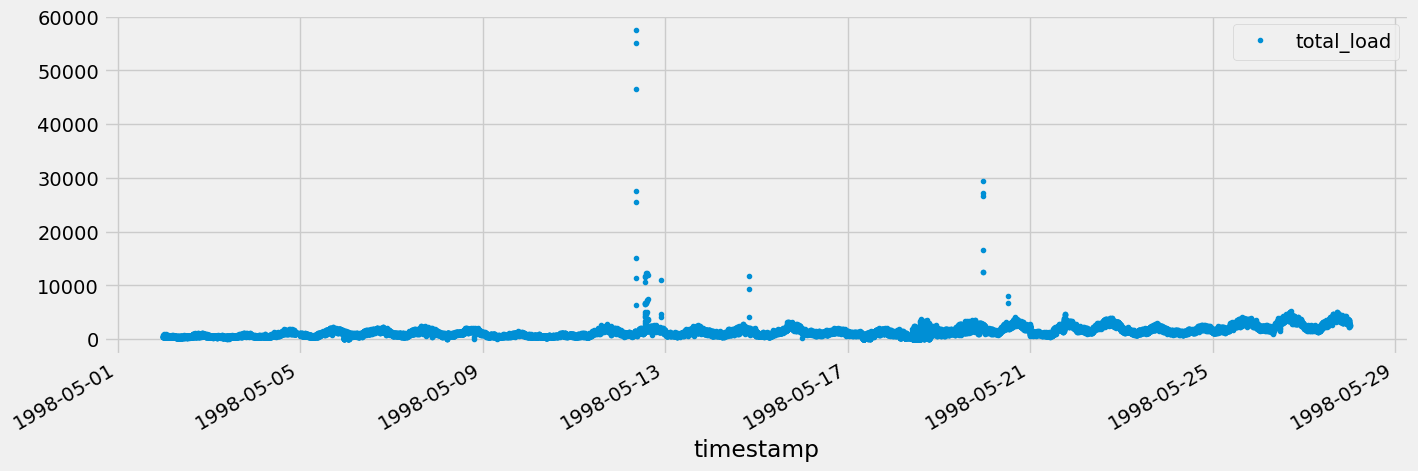

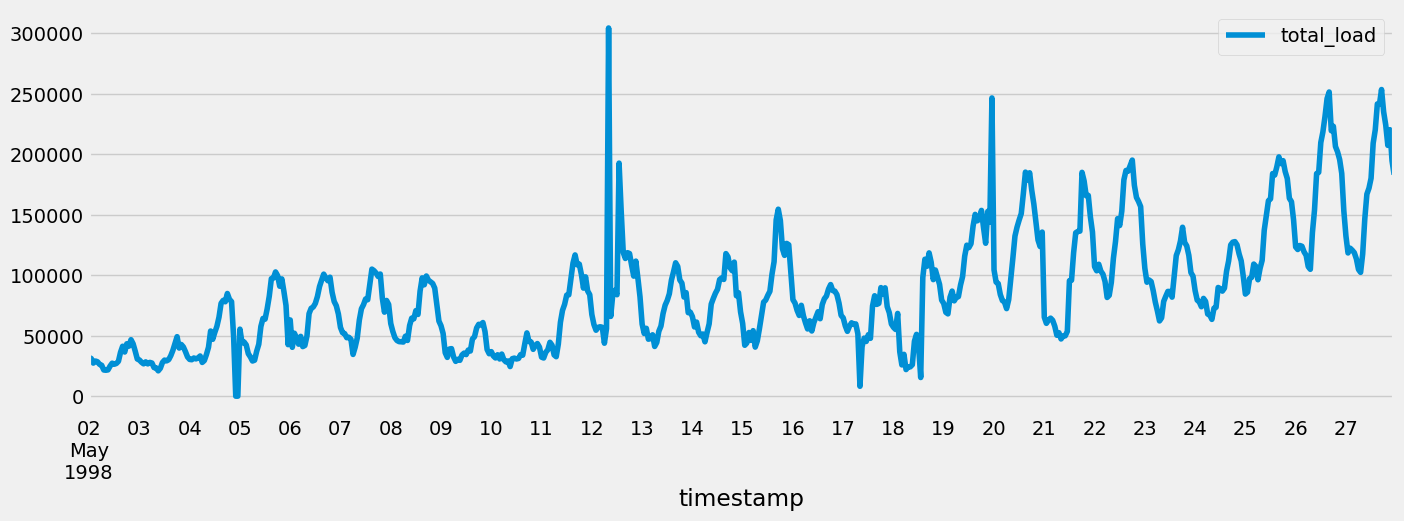

In [386]:
historical_df = pd.DataFrame(data_result, columns=['timestamp', 'average_load', 'total_load', 'instances'])
historical_df['timestamp'] = pd.to_datetime(historical_df['timestamp']) 
historical_df['total_load'] = historical_df['total_load'].astype(int)
#historical_df = historical_df[ historical_df['total_load']<6000] 
historical_df = historical_df.set_index("timestamp")
historical_df =historical_df.drop(columns=[ 'average_load', 'instances'])
historical_df.plot(style=".",figsize=(15,5))
historical_df.head()
# Resample the data per hour, round to nearest hour, and sum the total_load
hourly_sum = historical_df.resample('H').sum()
hourly_sum.plot(figsize=(15,5))
print(hourly_sum)

### Train/ Test Split

In [387]:
#Importing libs from tutorial
import seaborn as sns

import xgboost as xgb
from sklearn.metrics import mean_squared_error
color_pal = sns.color_palette()
plt.style.use('fivethirtyeight')

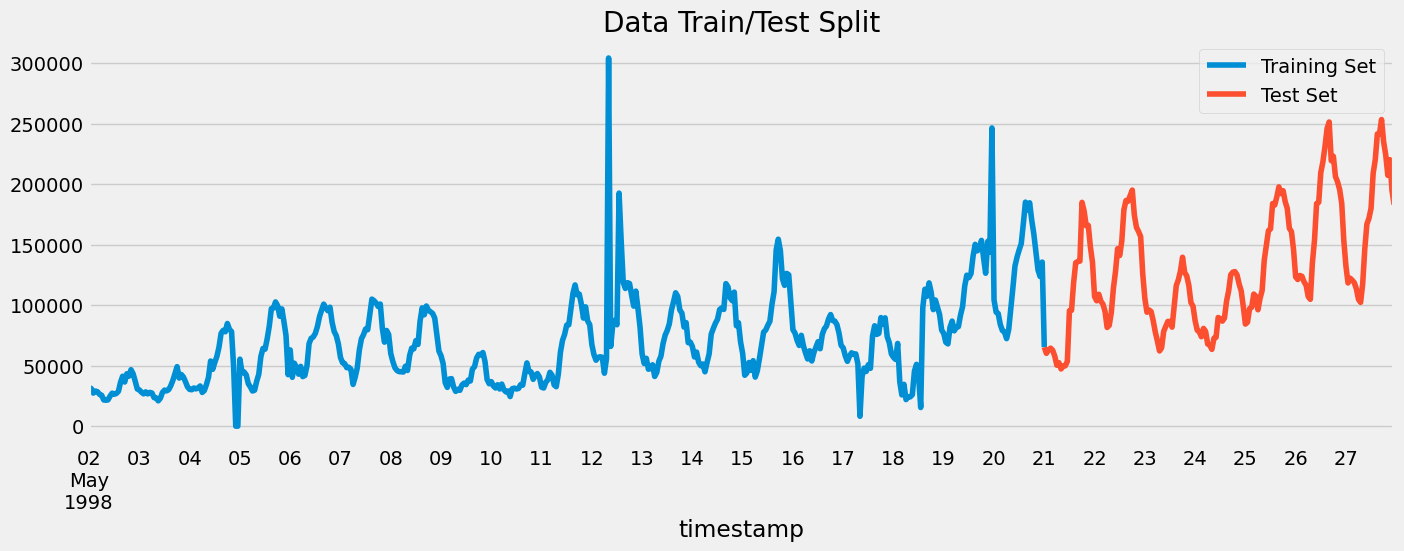

In [388]:
train = hourly_sum.loc[hourly_sum.index <= "1998-05-21 00:00:00"]
test = hourly_sum.loc[hourly_sum.index >= "1998-05-21 00:00:00"]
fig, ax = plt.subplots(figsize=(15, 5))
train.plot(ax=ax, label='Training Set', title='Data Train/Test Split')
test.plot(ax=ax, label='Test Set')
ax.legend(['Training Set', 'Test Set'])
plt.show()

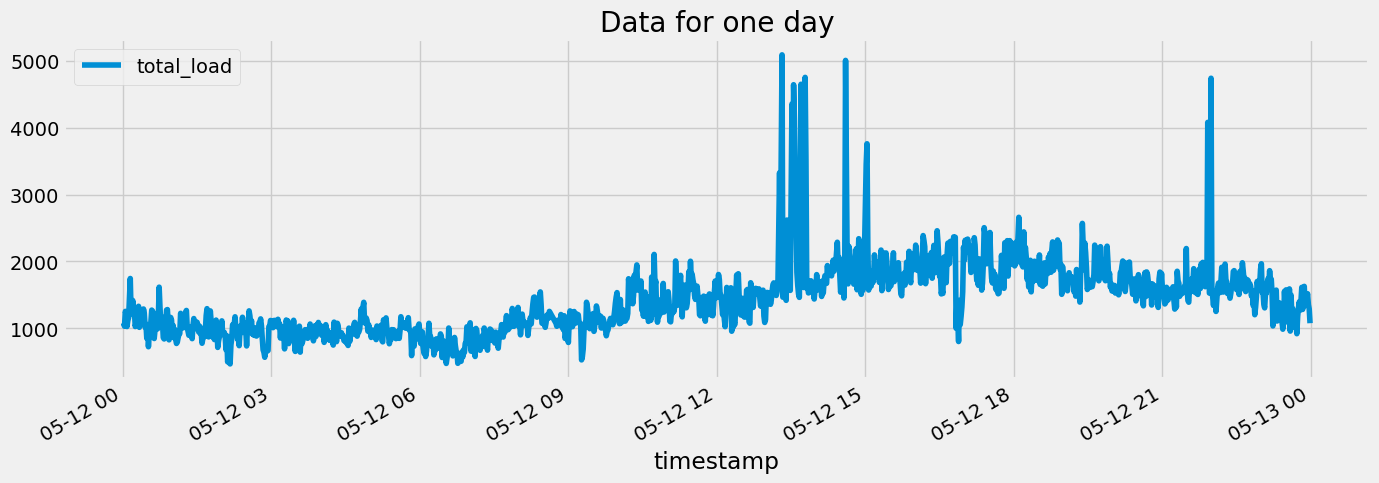

In [316]:
historical_df.loc[(historical_df.index > '1998-05-12 00:00:00') & (historical_df.index < '1998-05-13 00:00:00')] \
    .plot(figsize=(15, 5), title='Data for one day')
plt.show()

In [394]:
def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
   #df['minute'] = df.index.minute NOT NECESSARY
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    return df

df = create_features(hourly_sum)
df

,total_load,hour,dayofweek
timestamp,,,
1998-05-02 00:00:00,31969,0,5
1998-05-02 01:00:00,31132,1,5
1998-05-02 02:00:00,27349,2,5
1998-05-02 03:00:00,29052,3,5
1998-05-02 04:00:00,28462,4,5
...,...,...,...
1998-05-27 19:00:00,224150,19,2
1998-05-27 20:00:00,207295,20,2
1998-05-27 21:00:00,220285,21,2


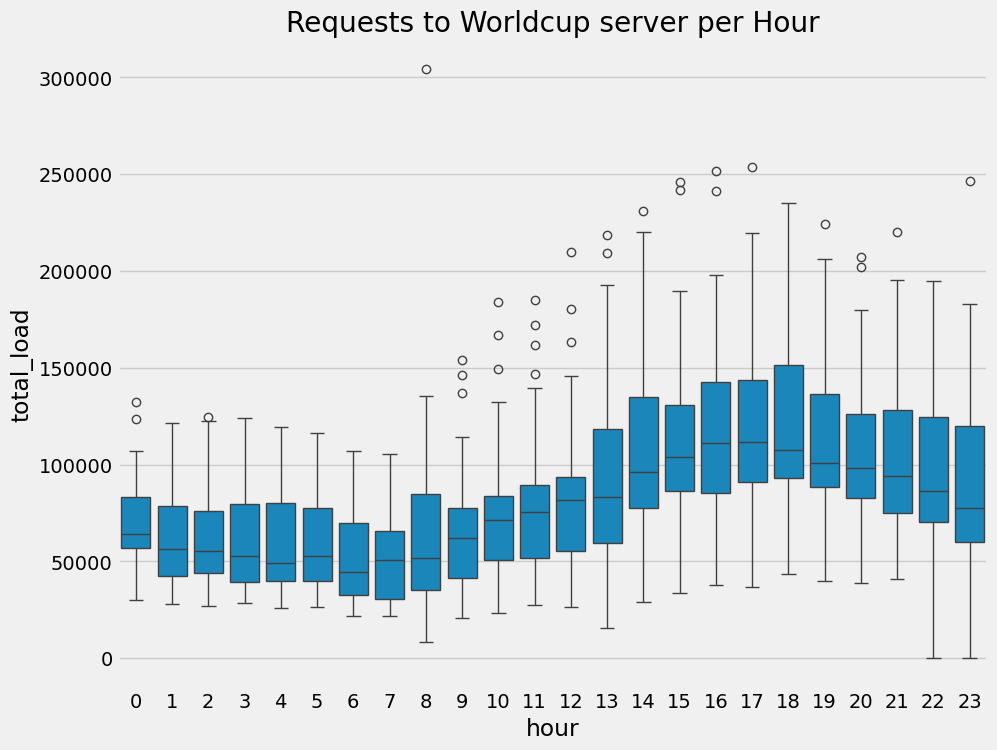

In [390]:
# Visualize

fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df, x='hour', y='total_load')
ax.set_title('Requests to Worldcup server per Hour')
plt.show()

Text(0.5, 1.0, 'Requests to Worldcup server per Hour (Without Outliers)')

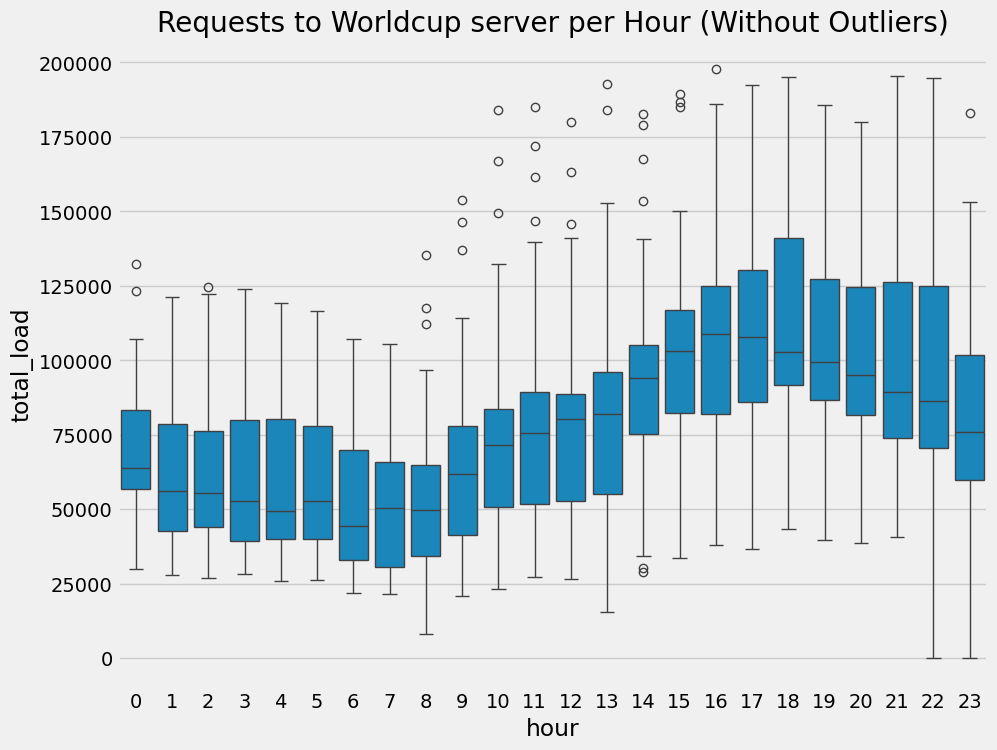

In [395]:
#Deleta outliers
# Assuming df is your DataFrame containing the data

Q1 = df['total_load'].quantile(0.25)
Q3 = df['total_load'].quantile(0.75)

IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_filtered = df[(df['total_load'] >= lower_bound) & (df['total_load'] <= upper_bound)]

# Plot the boxplot without outliers
fig, ax = plt.subplots(figsize=(10, 8))
sns.boxplot(data=df_filtered, x='hour', y='total_load')
ax.set_title('Requests to Worldcup server per Hour (Without Outliers)')

In [319]:
train = create_features(train)
test = create_features(test)

FEATURES = ['hour', 'dayofweek']
TARGET = 'total_load'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]

In [320]:
reg = xgb.XGBRegressor(n_estimators = 2000, early_stopping_rounds = 50,learning_rate=0.01)
reg.fit(X_train, y_train,
        eval_set=[(X_train, y_train), (X_test, y_test)],
        verbose=100)

[0]	validation_0-rmse:33123.67828	validation_1-rmse:59057.49617


[100]	validation_0-rmse:21731.32761	validation_1-rmse:52814.89086
[200]	validation_0-rmse:19249.58413	validation_1-rmse:51467.50423
[300]	validation_0-rmse:18737.16265	validation_1-rmse:51215.33400
[400]	validation_0-rmse:18621.57975	validation_1-rmse:51164.94990
[468]	validation_0-rmse:18595.05913	validation_1-rmse:51169.24176


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=50,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=2000, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

## Feature importances

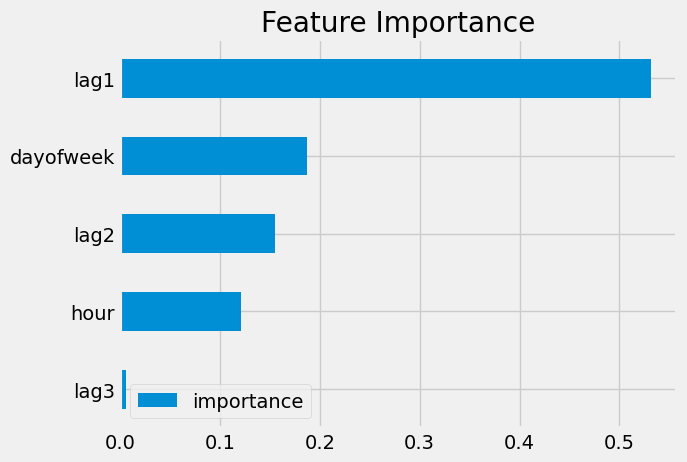

In [392]:
fi = pd.DataFrame(data=reg.feature_importances_,
             index=reg.feature_names_in_,
             columns=['importance'])
fi.sort_values('importance').plot(kind='barh', title='Feature Importance')
plt.show()

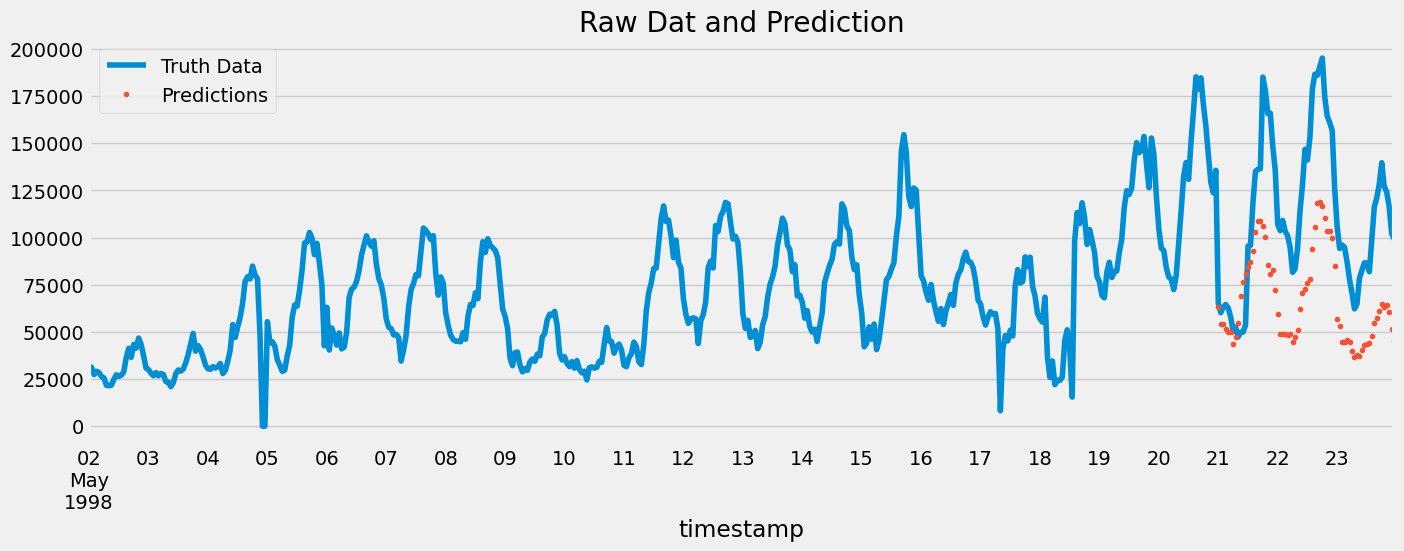

In [322]:
test['prediction'] = reg.predict(X_test)
df = df.merge(test[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['total_load']].plot(figsize=(15, 5))
df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()


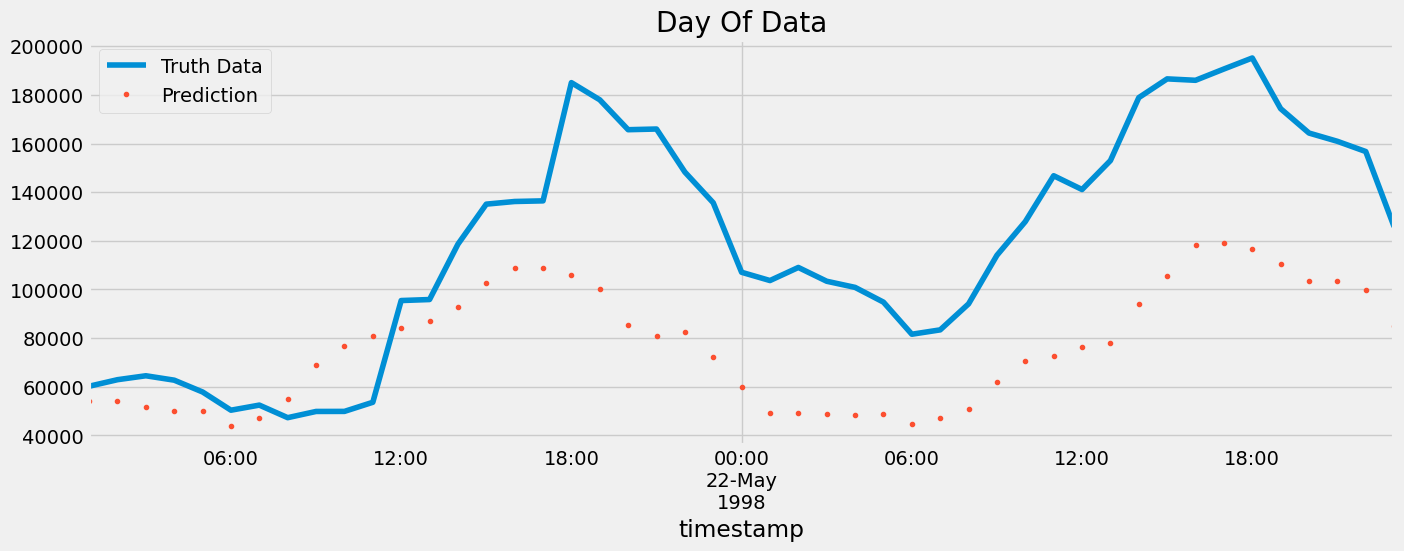

In [323]:
ax = df.loc[(df.index > '1998-05-21 00:00:00') & (df.index < '1998-05-23 00:00:00')]['total_load'] \
    .plot(figsize=(15, 5), title='Day Of Data')
df.loc[(df.index > '1998-05-21 00:00:00') & (df.index < '1998-05-23 00:00:00')]['prediction'] \
    .plot(style='.')
plt.legend(['Truth Data','Prediction'])
plt.show()


In [324]:
###För att kika vilka dagar som var sämst predictade

score = np.sqrt(mean_squared_error(test['total_load'], test['prediction']))
print(f'RMSE Score on Test set: {score:0.2f}')
test['error'] = np.abs(test[TARGET] - test['prediction'])
test['date'] = test.index.date
test.groupby(['date'])['error'].mean().sort_values(ascending=False).head(10)

RMSE Score on Test set: 51160.80


date
1998-05-22    59111.847656
1998-05-23    48388.765951
1998-05-21    30277.480632
Name: error, dtype: float64

### Skapa framtida prediktion!

In [396]:
from datetime import timedelta
last_date = historical_df.index.max().replace(hour=0, minute=0, second=0)
next_five_days_dates = pd.date_range(start=last_date+timedelta(days=1), end=last_date +timedelta(days=16), freq='T')


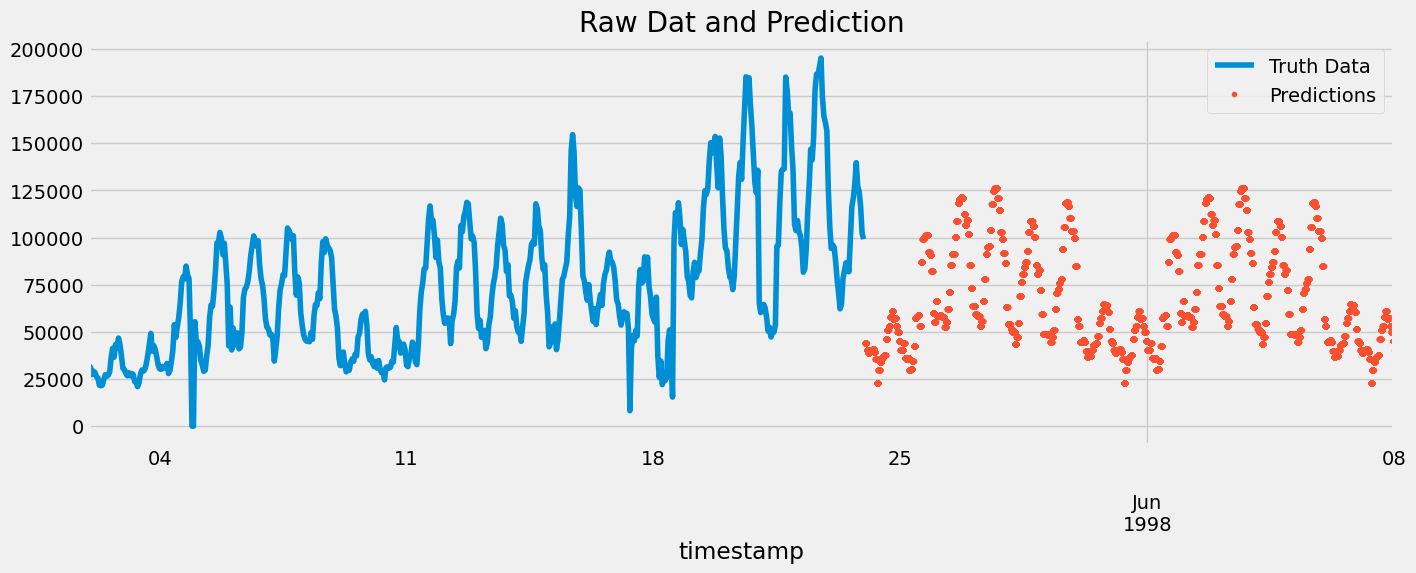

In [330]:
next_days_df = pd.DataFrame(next_five_days_dates, columns=["timestamp"])
next_days_df = next_days_df.set_index("timestamp")
next_day_test = create_features(next_days_df)
next_days_df['prediction'] = reg.predict(next_day_test)
#df = df.merge(next_days_df[['prediction']], how='left', left_index=True, right_index=True)
ax = df[['total_load']].plot(figsize=(15, 5))
next_days_df['prediction'].plot(ax=ax, style='.')
plt.legend(['Truth Data', 'Predictions'])
ax.set_title('Raw Dat and Prediction')
plt.show()

## Time series Cross Validation

In [397]:
from sklearn.model_selection import TimeSeriesSplit

In [398]:
tss = TimeSeriesSplit(n_splits = 5, test_size = 24, gap=1) #hour/dayofweek
df = df_filtered.sort_index()
df.tail()

,total_load,hour,dayofweek
timestamp,,,
1998-05-27 10:00:00,167004,10,2
1998-05-27 11:00:00,171924,11,2
1998-05-27 12:00:00,180111,12,2
1998-05-27 22:00:00,194658,22,2
1998-05-27 23:00:00,183122,23,2


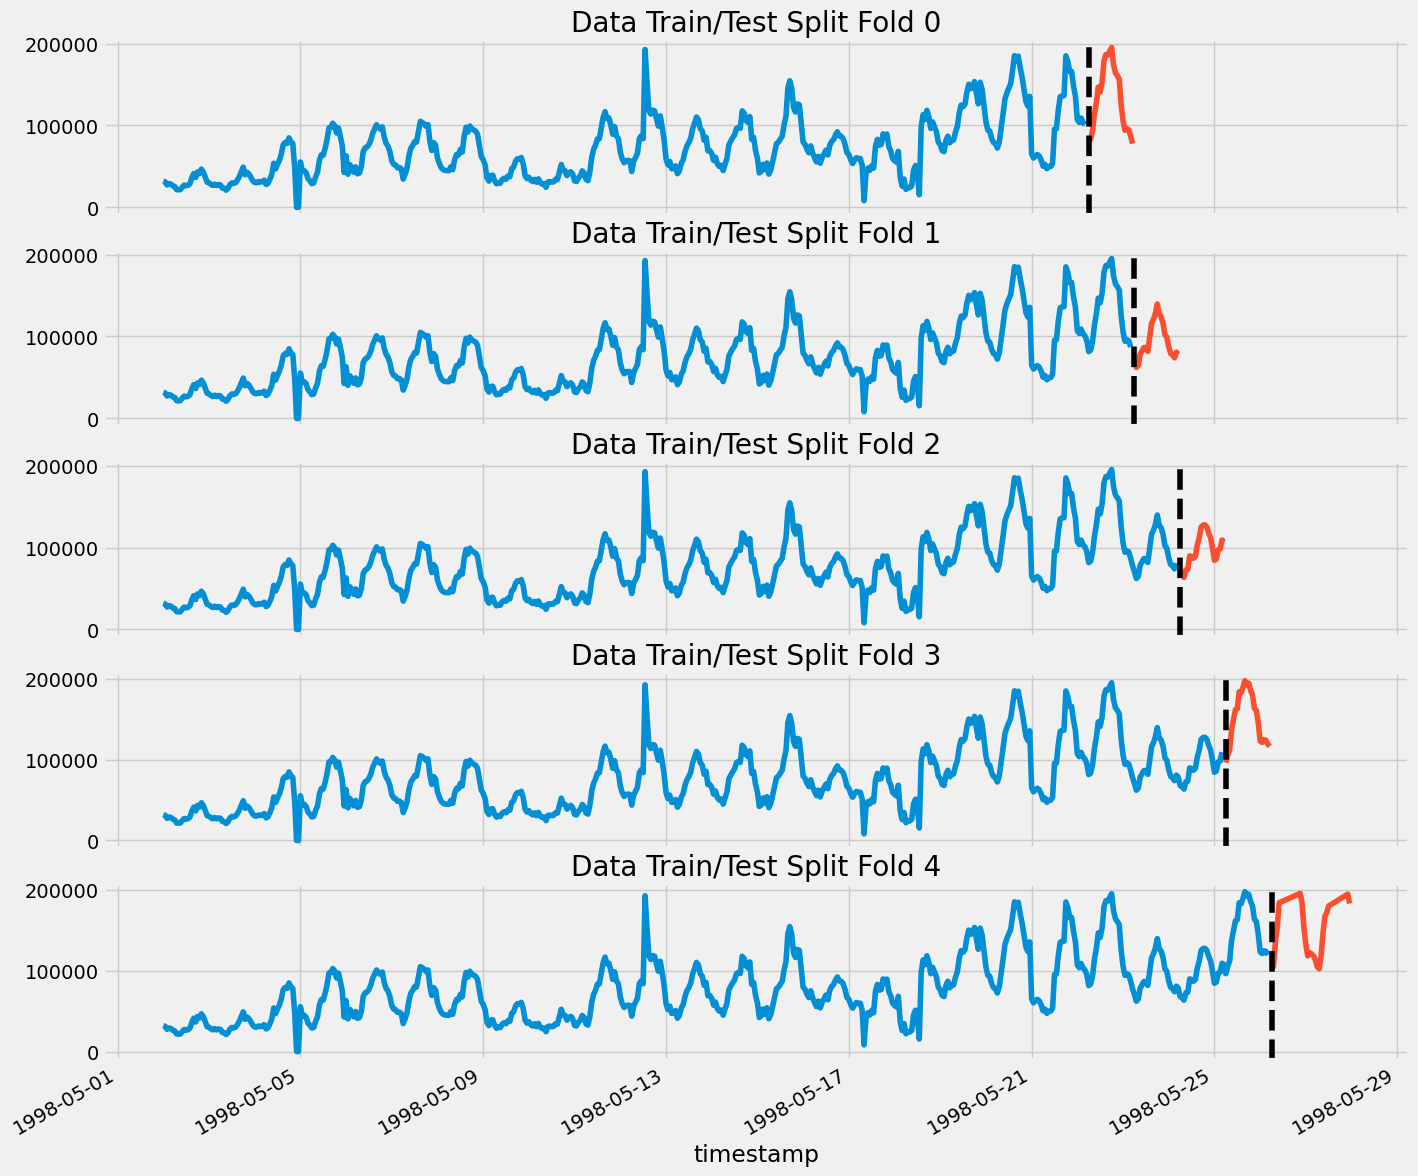

In [399]:
fig, axs = plt.subplots(5, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train['total_load'].plot(ax=axs[fold],
                          label='Training Set',
                          title=f'Data Train/Test Split Fold {fold}')
    test['total_load'].plot(ax=axs[fold],
                         label='Test Set')
    axs[fold].axvline(test.index.min(), color='black', ls='--')
    fold += 1
plt.show()

## Lag filters

Look back in to the past, use the target value for that many days in the past. What was the trarget(x) in the past?

In [400]:
def add_lags(df):
    target_map = df['total_load'].to_dict()
    df['lag1'] = (df.index - pd.Timedelta('7 days')).map(target_map)
    df['lag2'] = (df.index - pd.Timedelta('14 days')).map(target_map)
    df['lag3'] = (df.index - pd.Timedelta('21 days')).map(target_map)
    return df
df = add_lags(df)
df.tail()

,total_load,hour,dayofweek,lag1,lag2,lag3
timestamp,,,,,,
1998-05-27 10:00:00,167004,10,2,132381.0,68293.0,72620.0
1998-05-27 11:00:00,171924,11,2,139763.0,75240.0,73713.0
1998-05-27 12:00:00,180111,12,2,145640.0,79140.0,76682.0
1998-05-27 22:00:00,194658,22,2,123710.0,69024.0,74778.0
1998-05-27 23:00:00,183122,23,2,135627.0,69449.0,67932.0


Train using the CV and the lag filters

In [402]:
tss = TimeSeriesSplit(n_splits=10, test_size=24, gap=24)
df = df.sort_index()


fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_features(train)
    test = create_features(test)

    FEATURES = ['hour', 'dayofweek',
                'lag1','lag2','lag3']
    TARGET = 'total_load'
    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(base_score=0.5, booster='gbtree',    
                           n_estimators=1000,
                           early_stopping_rounds=50,
                           objective='reg:linear',
                           max_depth=3,
                           learning_rate=0.01)
    reg.fit(X_train, y_train,
            eval_set=[(X_train, y_train), (X_test, y_test)],
            verbose=100)

    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)

[0]	validation_0-rmse:67693.25337	validation_1-rmse:62403.56165
[100]	validation_0-rmse:28357.43885	validation_1-rmse:33216.91836


/Users/admin/anaconda3/envs/exjobb/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [14:13:29] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[200]	validation_0-rmse:15073.62699	validation_1-rmse:21766.60297
[300]	validation_0-rmse:10866.47698	validation_1-rmse:19810.48083
[400]	validation_0-rmse:9147.04581	validation_1-rmse:18227.71355
[500]	validation_0-rmse:8382.31326	validation_1-rmse:17882.35112
[514]	validation_0-rmse:8289.18748	validation_1-rmse:17908.12636
[0]	validation_0-rmse:67863.41034	validation_1-rmse:76816.05718
[100]	validation_0-rmse:28579.24753	validation_1-rmse:30553.83567
[200]	validation_0-rmse:15195.08073	validation_1-rmse:25067.84580
[220]	validation_0-rmse:13890.91180	validation_1-rmse:25441.03776
[0]	validation_0-rmse:67535.48724	validation_1-rmse:117039.76004


/Users/admin/anaconda3/envs/exjobb/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [14:13:29] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)
/Users/admin/anaconda3/envs/exjobb/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [14:13:29] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:28932.11781	validation_1-rmse:63414.48714
[200]	validation_0-rmse:15426.71394	validation_1-rmse:43436.17244
[300]	validation_0-rmse:11400.47352	validation_1-rmse:35891.44302
[400]	validation_0-rmse:9825.01567	validation_1-rmse:32531.28039
[500]	validation_0-rmse:9104.08602	validation_1-rmse:31528.28762
[600]	validation_0-rmse:8652.52474	validation_1-rmse:30945.33239
[660]	validation_0-rmse:8464.18727	validation_1-rmse:31016.90708
[0]	validation_0-rmse:68118.12319	validation_1-rmse:126967.81219
[100]	validation_0-rmse:29176.37856	validation_1-rmse:76013.47828
[200]	validation_0-rmse:15899.36521	validation_1-rmse:58627.67140
[300]	validation_0-rmse:11863.82478	validation_1-rmse:52164.89042


/Users/admin/anaconda3/envs/exjobb/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [14:13:30] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[400]	validation_0-rmse:10248.37418	validation_1-rmse:48109.21297
[500]	validation_0-rmse:9703.28369	validation_1-rmse:47136.58808
[600]	validation_0-rmse:9358.64322	validation_1-rmse:46568.71011
[700]	validation_0-rmse:8939.60069	validation_1-rmse:46484.39127
[793]	validation_0-rmse:8644.50403	validation_1-rmse:46529.71528
[0]	validation_0-rmse:71659.74116	validation_1-rmse:116084.31285
[100]	validation_0-rmse:30752.10468	validation_1-rmse:62310.79547
[200]	validation_0-rmse:16607.01754	validation_1-rmse:43196.05412
[300]	validation_0-rmse:12145.84229	validation_1-rmse:35963.61626


/Users/admin/anaconda3/envs/exjobb/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [14:13:30] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[400]	validation_0-rmse:10377.39069	validation_1-rmse:34483.08413
[500]	validation_0-rmse:9629.61712	validation_1-rmse:33792.86045
[600]	validation_0-rmse:9274.60018	validation_1-rmse:33523.67556
[700]	validation_0-rmse:8959.05872	validation_1-rmse:33350.13526
[800]	validation_0-rmse:8657.43406	validation_1-rmse:33150.98633
[900]	validation_0-rmse:8336.29218	validation_1-rmse:32752.28469
[999]	validation_0-rmse:8047.72653	validation_1-rmse:32338.26451
[0]	validation_0-rmse:75517.26678	validation_1-rmse:138619.40205
[100]	validation_0-rmse:32124.46289	validation_1-rmse:68494.68413
[200]	validation_0-rmse:17399.02436	validation_1-rmse:40440.31854


/Users/admin/anaconda3/envs/exjobb/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [14:13:31] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[300]	validation_0-rmse:12749.84074	validation_1-rmse:28654.46863
[400]	validation_0-rmse:10944.70560	validation_1-rmse:24643.76171
[500]	validation_0-rmse:10195.82026	validation_1-rmse:23278.01188
[600]	validation_0-rmse:9847.57907	validation_1-rmse:22377.02651
[700]	validation_0-rmse:9559.35312	validation_1-rmse:22028.68798
[800]	validation_0-rmse:9241.65272	validation_1-rmse:21374.71871
[900]	validation_0-rmse:8914.18182	validation_1-rmse:20910.53393
[999]	validation_0-rmse:8658.79900	validation_1-rmse:20625.56538
[0]	validation_0-rmse:78014.39524	validation_1-rmse:96232.54019
[100]	validation_0-rmse:33453.80568	validation_1-rmse:49690.58378
[200]	validation_0-rmse:18684.41441	validation_1-rmse:31541.09508


/Users/admin/anaconda3/envs/exjobb/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [14:13:32] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[300]	validation_0-rmse:14148.29368	validation_1-rmse:25220.21447
[400]	validation_0-rmse:12474.40280	validation_1-rmse:22460.95172
[500]	validation_0-rmse:11682.10634	validation_1-rmse:20853.34235
[600]	validation_0-rmse:11278.86214	validation_1-rmse:20271.82675
[700]	validation_0-rmse:10954.51482	validation_1-rmse:19556.97266
[800]	validation_0-rmse:10496.25612	validation_1-rmse:18413.24297
[878]	validation_0-rmse:10192.40176	validation_1-rmse:18276.85339
[0]	validation_0-rmse:81876.63749	validation_1-rmse:98510.80071
[100]	validation_0-rmse:34854.20543	validation_1-rmse:53803.25249
[200]	validation_0-rmse:19485.90655	validation_1-rmse:37563.23570


/Users/admin/anaconda3/envs/exjobb/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [14:13:33] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[300]	validation_0-rmse:14531.53957	validation_1-rmse:32962.79824
[400]	validation_0-rmse:12759.79604	validation_1-rmse:32136.03897
[409]	validation_0-rmse:12666.55939	validation_1-rmse:32126.80874
[0]	validation_0-rmse:82564.58856	validation_1-rmse:153558.96063
[100]	validation_0-rmse:35200.75187	validation_1-rmse:98131.44241
[200]	validation_0-rmse:19423.21733	validation_1-rmse:76658.96067


/Users/admin/anaconda3/envs/exjobb/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [14:13:34] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[300]	validation_0-rmse:14446.01075	validation_1-rmse:72241.13576
[400]	validation_0-rmse:12666.19019	validation_1-rmse:70936.17672
[424]	validation_0-rmse:12444.85790	validation_1-rmse:71067.95083
[0]	validation_0-rmse:83292.23305	validation_1-rmse:148053.92992
[100]	validation_0-rmse:35363.96307	validation_1-rmse:80187.17051
[200]	validation_0-rmse:19634.38468	validation_1-rmse:56469.61149
[300]	validation_0-rmse:14719.41819	validation_1-rmse:47185.60464


/Users/admin/anaconda3/envs/exjobb/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [14:13:34] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[400]	validation_0-rmse:12872.14022	validation_1-rmse:43216.53574
[500]	validation_0-rmse:11920.15483	validation_1-rmse:41195.87610
[574]	validation_0-rmse:11528.75063	validation_1-rmse:41138.35050


In [403]:
print(f'Score across folds {np.mean(scores):0.4f}')
print(f'Fold scores:{scores}')

Score across folds 33460.0306
Fold scores:[17744.70024101016, 24819.104108656753, 30926.93939988895, 46466.29302826979, 32338.264342601764, 20622.945012868975, 18148.229464879983, 32058.372241087676, 70479.14160273093, 40996.316422130185]


## Predict the future

In [404]:
# Retrain on all data
df = create_features(df)

FEATURES = ['hour', 'dayofweek',
                'lag1','lag2','lag3']
TARGET = 'total_load'

X_all = df[FEATURES]
y_all = df[TARGET]

reg = xgb.XGBRegressor(base_score=0.5,
                       booster='gbtree',    
                       n_estimators=3000,
                       objective='reg:linear',
                       max_depth=3,
                       learning_rate=0.01)
reg.fit(X_all, y_all,
        eval_set=[(X_all, y_all)],
        verbose=100)

[0]	validation_0-rmse:90473.54167


/Users/admin/anaconda3/envs/exjobb/lib/python3.11/site-packages/xgboost/core.py:160: UserWarning: [14:14:13] WARNING: /Users/runner/work/xgboost/xgboost/src/objective/regression_obj.cu:209: reg:linear is now deprecated in favor of reg:squarederror.
  warnings.warn(smsg, UserWarning)


[100]	validation_0-rmse:38441.07954
[200]	validation_0-rmse:20968.29000
[300]	validation_0-rmse:15380.83704
[400]	validation_0-rmse:13454.58966
[500]	validation_0-rmse:12483.37020
[600]	validation_0-rmse:11849.14596
[700]	validation_0-rmse:11312.48008
[800]	validation_0-rmse:10872.91209
[900]	validation_0-rmse:10503.33930
[1000]	validation_0-rmse:10228.00429
[1100]	validation_0-rmse:9957.63018
[1200]	validation_0-rmse:9676.83221
[1300]	validation_0-rmse:9446.00293
[1400]	validation_0-rmse:9253.13909
[1500]	validation_0-rmse:9085.31714
[1600]	validation_0-rmse:8933.79756
[1700]	validation_0-rmse:8783.41928
[1800]	validation_0-rmse:8604.29564
[1900]	validation_0-rmse:8469.62503
[2000]	validation_0-rmse:8336.38158
[2100]	validation_0-rmse:8249.67002
[2200]	validation_0-rmse:8068.47354
[2300]	validation_0-rmse:7906.69547
[2400]	validation_0-rmse:7799.90873
[2500]	validation_0-rmse:7714.56595
[2600]	validation_0-rmse:7637.44511
[2700]	validation_0-rmse:7560.71292
[2800]	validation_0-rmse:74

XGBRegressor(base_score=0.5, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=3000, n_jobs=None,
             num_parallel_tree=None, objective='reg:linear', ...)

In [415]:
df.index.max()
# Create future dataframe
future = pd.date_range('1998-05-27 23:00:00','1998-06-05 00:00:00', freq='1h')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)
df_and_future = add_lags(df_and_future)

future_w_features = df_and_future.query('isFuture').copy()
future_w_features
df_and_future


,total_load,hour,dayofweek,lag1,lag2,lag3,isFuture
1998-05-02 00:00:00,31969.0,0,5,NaN,NaN,NaN,False
1998-05-02 01:00:00,31132.0,1,5,NaN,NaN,NaN,False
1998-05-02 02:00:00,27349.0,2,5,NaN,NaN,NaN,False
1998-05-02 03:00:00,29052.0,3,5,NaN,NaN,NaN,False
1998-05-02 04:00:00,28462.0,4,5,NaN,NaN,NaN,False
...,...,...,...,...,...,...,...
1998-06-04 20:00:00,NaN,20,3,NaN,165674.0,110814.0,True
1998-06-04 21:00:00,NaN,21,3,NaN,165954.0,83006.0,True
1998-06-04 22:00:00,NaN,22,3,NaN,148252.0,85530.0,True
1998-06-04 23:00:00,NaN,23,3,NaN,135631.0,69637.0,True


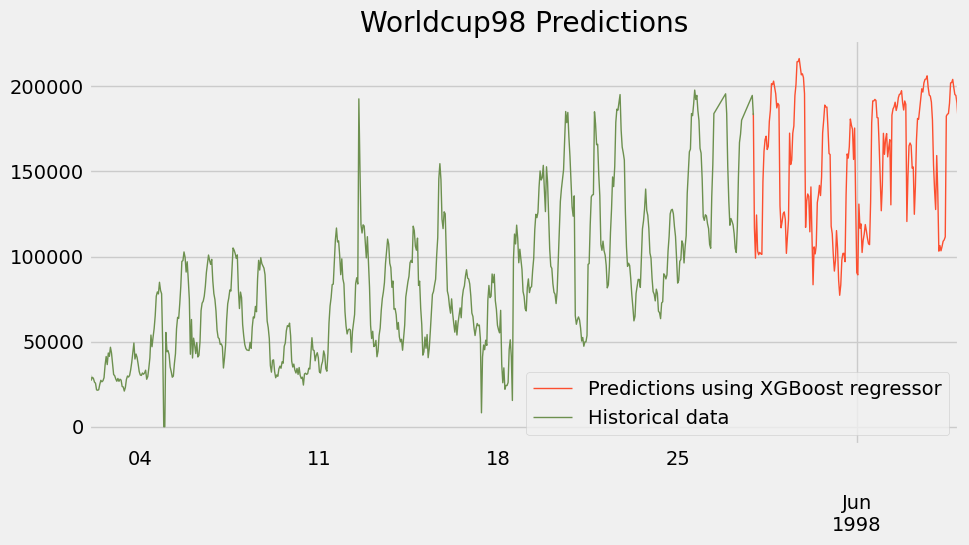

In [416]:
future_w_features['pred'] = reg.predict(future_w_features[FEATURES])

future_w_features['pred'].plot(figsize=(10, 5),
                               color=color_pal[1],
                               ms=1,
                               lw=1,
                               title='Worldcup98 Predictions')

df_and_future['total_load'].plot(figsize=(10, 5),
                               color=color_pal[3],
                               ms=1,
                               lw=1,)
plt.legend(['Predictions using XGBoost regressor','Historical data'])

plt.show()

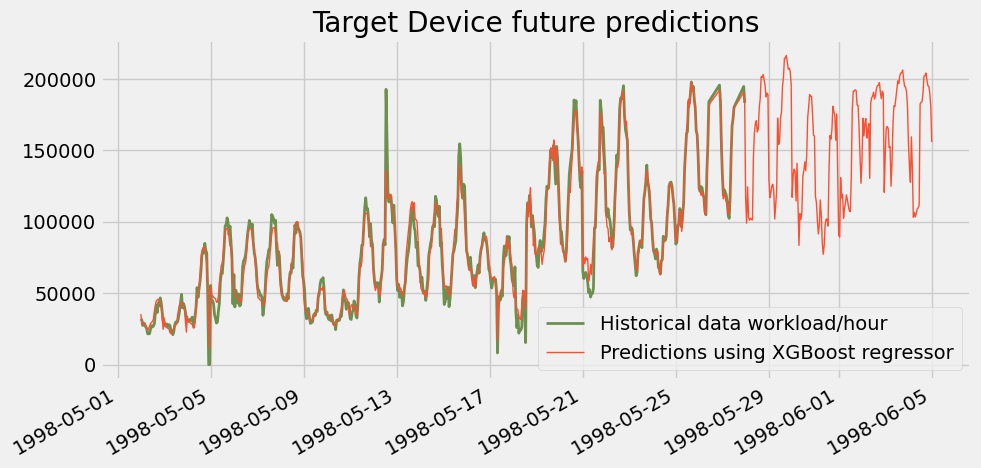

In [417]:
df_and_future['pred'] = reg.predict(df_and_future[FEATURES])


df_and_future['total_load'].plot(figsize=(10, 5),
                               color=color_pal[3],
                               ms=2,
                               lw=2,)
df_and_future['pred'].plot(figsize=(10, 5),
                               color=color_pal[1],
                               ms=1,
                               lw=1,
                               title='Target Device future predictions')
plt.legend(['Historical data workload/hour ','Predictions using XGBoost regressor'])

plt.show()


# Här kommer kod sen innan! Allt ovanför följer youtube tutorialom XGBoost

In [200]:
#Small effort do delete outliers
# calculate summary statistics
data_mean, data_std = mean(historical_df["total_load"]), std(historical_df["total_load"])
cut_off = data_std * 1 #Räknas som outliers om de är mer än 2 standard deviations från medelvärdet. 
lower, upper = data_mean - cut_off, data_mean + cut_off
print(lower,upper)
print(data_mean)

outliers = [x for x in historical_df["total_load"] if x < lower or x > upper]
print('Identified outliers: %d' % len(outliers))
...
outliers_removed = [x for x in historical_df["total_load"] if x > lower and x < upper]
print(len(outliers_removed))
historical_df_outliers_removed = historical_df[(historical_df["total_load"] > lower) & (historical_df["total_load"] < upper)]


179.79130785156258 1930.7323596847773
1055.26183376817
Identified outliers: 1017
20447


In [248]:
X = historical_df['timestamp'].astype(int).values.reshape(-1, 1)
y = historical_df['total_load'].values.reshape(-1, 1)
print(X,y)

[[894067200000000000]
 [894067260000000000]
 [894067320000000000]
 ...
 [895363020000000000]
 [895363080000000000]
 [895363140000000000]] [[ 352]
 [ 373]
 [ 401]
 ...
 [ 957]
 [1252]
 [ 987]]


In [85]:
##Scale the data. This part doesnt work as expected.

sc_X = StandardScaler()
sc_y = StandardScaler()
X = sc_X.fit_transform(X)
y = sc_y.fit_transform(y)
print(X,y)

[[-1.73557606]
 [-1.73535727]
 [-1.73513848]
 ...
 [ 1.72934782]
 [ 1.7295666 ]
 [ 1.72978539]] [[-1.27776128]
 [-1.23208847]
 [-1.17119138]
 ...
 [ 0.89713476]
 [ 0.75794141]
 [ 0.29468856]]


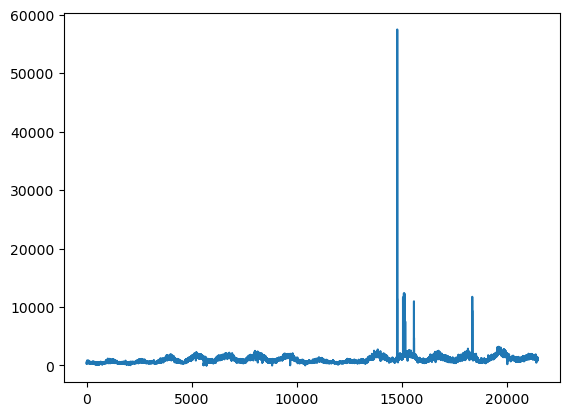

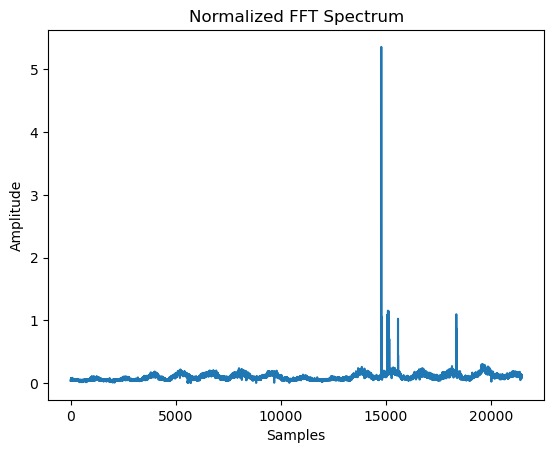

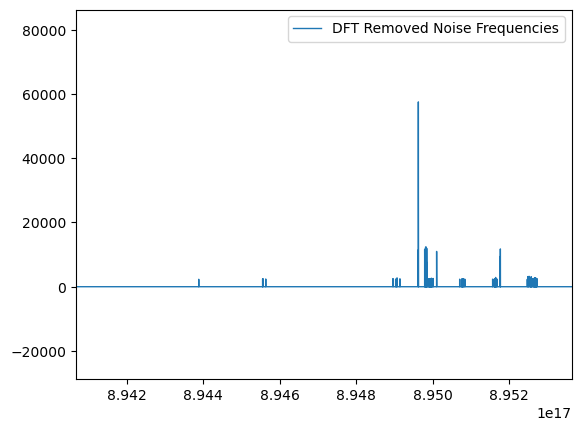

In [250]:
##Fourier aproximation FUNKAR EJ
# Apply the FFT on the signal
fourier = fft(y)

# Plot the result (the spectrum |Xk|)
plt.plot(np.abs(fourier))
plt.show()

N = len(y)
normalize = N/2

# Plot the normalized FFT (|Xk|)/(N/2)
plt.plot(np.abs(fourier)/normalize)
plt.ylabel('Amplitude')
plt.xlabel('Samples')
plt.title('Normalized FFT Spectrum')
plt.show()

yf_abs      = np.abs(y) 
indices     = yf_abs>2300   # filter out those value under 300
yfClean    = indices * y # noise frequency will be set to 0
plt.plot(X,np.abs(yfClean),linewidth=1,label="DFT Removed Noise Frequencies")
plt.margins(x=0, y=0.5)
plt.legend()
plt.show()


In [223]:
X_data, X_test, y_data, y_test = train_test_split(X, y, test_size=0.1, random_state=42)

X_train, X_val, y_train, y_val = train_test_split(X_data, y_data, test_size=(0.2/0.9), random_state=42) #Taget från intelligenta

In [204]:
# Model Evaluation
##Linear regression
model = LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)


Mean Squared Error: 151212.3521888552


In [32]:
#Support vector machines
# Train SVR model with polynomial kernel
poly_svr = make_pipeline(StandardScaler(), SVR(kernel='poly', degree=5, C=100, gamma="auto", epsilon=0.1, coef0=1))  # Adjust degree as needed
poly_svr.fit(X_train, y_train)
# Predict workload
y_pred = poly_svr.predict(X_test)

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)


Mean Squared Error: 132627.36284775936


In [67]:

# Initialize variables to store best degree and corresponding MSE
best_degree = None
best_mse = float('inf')  # Initialize with a large value

# Try different degrees
for degree in range(1, 6):  # Try degrees 1 to 5
    # Train SVR model with polynomial kernel
    poly_svr = make_pipeline(StandardScaler(), SVR(kernel='rbf', degree=degree))
    poly_svr.fit(X_train, y_train)

    # Predict workload on validation set
    y_pred = poly_svr.predict(X_val)

    # Calculate Mean Squared Error
    mse = mean_squared_error(y_val, y_pred)

    # Check if current degree gives lower MSE
    if mse < best_mse:
        best_mse = mse
        best_degree = degree

# Print the best degree and corresponding MSE
print("Best Degree:", best_degree)
print("Best MSE:", best_mse)

Best Degree: 1
Best MSE: 141895.00995225305


In [225]:
## Trying SVM with regression 
svr = SVR(C=1.0, epsilon=0.2).fit(X_train, y_train)
# Predict workload
y_pred = svr.predict(X_test)

# Calculate Mean Squared Error
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
score = svr.score(X,y)
print("R-squared:", score)


/Users/admin/anaconda3/envs/exjobb/lib/python3.11/site-packages/sklearn/utils/validation.py:1300: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


Mean Squared Error: 188461.48591859464


ValueError: X has 1 features, but SVR is expecting 100 features as input.

SVR()


In [139]:
## Decision Tree
tree_model = DecisionTreeRegressor()
tree_model.fit(X_train, y_train)
y_pred_tree = tree_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred_tree)
print("Mean Squared Error:", mse)


Mean Squared Error: 22814.734977139124


In [140]:
## Random Forests
forest_model = RandomForestRegressor(max_depth= 10,min_samples_leaf = 1, min_samples_split = 10, n_estimators = 300)
forest_model.fit(X_train, y_train)
y_pred_forest = forest_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred_forest)
print("Mean Squared Error:", mse)

/Users/admin/anaconda3/envs/exjobb/lib/python3.11/site-packages/sklearn/base.py:1474: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Mean Squared Error: 22569.017421441826


In [ ]:
# parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],  # Number of trees in the forest
    'max_depth': [None, 10, 20],        # Maximum depth of the trees
    'min_samples_split': [2, 5, 10],    # Minimum number of samples required to split an internal node
    'min_samples_leaf': [1, 2, 4]       # Minimum number of samples required to be at a leaf node
}

forest_model = RandomForestRegressor()

grid_search = GridSearchCV(forest_model, param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

best_forest_model = grid_search.best_estimator_
y_pred_forest = best_forest_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred_forest)
print("Mean Squared Error:", mse)

print("Best Parameters:", grid_search.best_params_)

Mean Squared Error: 183.56072563159594
Best Parameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 300}


In [138]:

## Gradient Boosting
gbm_model = GradientBoostingRegressor()
gbm_model.fit(X_train, y_train)
y_pred_gbm = gbm_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred_gbm)
print("Mean Squared Error:", mse)

/Users/admin/anaconda3/envs/exjobb/lib/python3.11/site-packages/sklearn/ensemble/_gb.py:668: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)  # TODO: Is this still required?


Mean Squared Error: 24500.401071219083


In [112]:
knn_regressor = KNeighborsRegressor(n_neighbors=3)
knn_regressor.fit(X_train, y_train)
y_pred = knn_regressor.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print("Mean Squared Error:", mse)
hyperparameters = {'n_neighbors': np.arange(1,30,1)}


Mean Squared Error: 16951.350847337446


In [219]:
last_date = historical_df_outliers_removed['timestamp'].max()
first_date = historical_df_outliers_removed['timestamp'].min()
next_day = last_date + pd.DateOffset(days=1)

#Prepare next day timestamps, starting from the beginning of the next day 
next_day_timestamps = pd.date_range(start=next_day.replace(hour=0, minute=0, second=0), end=next_day+ pd.DateOffset(days=1), freq='T')
all_days= pd.date_range(start=first_date.replace(hour=0, minute=0, second=0), end=next_day+ pd.DateOffset(days=1), freq='T')
print(next_day_timestamps)
print(all_days)

DatetimeIndex(['1998-05-17 00:00:00', '1998-05-17 00:01:00',
               '1998-05-17 00:02:00', '1998-05-17 00:03:00',
               '1998-05-17 00:04:00', '1998-05-17 00:05:00',
               '1998-05-17 00:06:00', '1998-05-17 00:07:00',
               '1998-05-17 00:08:00', '1998-05-17 00:09:00',
               ...
               '1998-05-18 23:50:00', '1998-05-18 23:51:00',
               '1998-05-18 23:52:00', '1998-05-18 23:53:00',
               '1998-05-18 23:54:00', '1998-05-18 23:55:00',
               '1998-05-18 23:56:00', '1998-05-18 23:57:00',
               '1998-05-18 23:58:00', '1998-05-18 23:59:00'],
              dtype='datetime64[ns]', length=2880, freq='T')
DatetimeIndex(['1998-05-02 00:00:00', '1998-05-02 00:01:00',
               '1998-05-02 00:02:00', '1998-05-02 00:03:00',
               '1998-05-02 00:04:00', '1998-05-02 00:05:00',
               '1998-05-02 00:06:00', '1998-05-02 00:07:00',
               '1998-05-02 00:08:00', '1998-05-02 00:09:00',
    

In [220]:
next_day_predictions = model.predict(next_day_timestamps.astype(int).values.reshape(-1, 1))  # Use your model to predict workload for next_day_timestamps
all_day_predictions = svr.predict(all_days.astype(int).values.reshape(-1, 1))
print(all_day_predictions)


[ 473.70145474  473.72024949  473.73908263 ... 1036.21991117 1036.17872824
 1036.13754962]


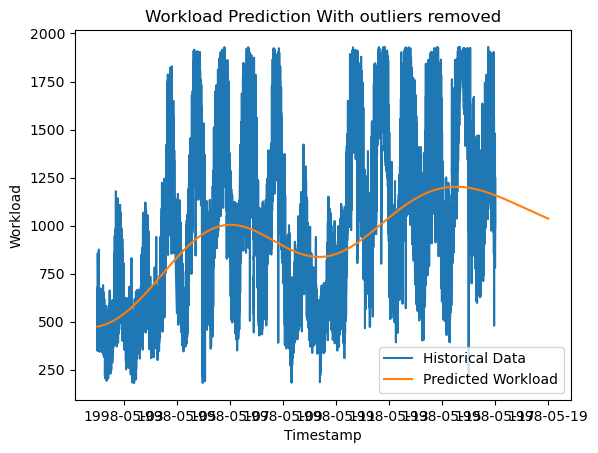

In [221]:
plt.plot(historical_df_outliers_removed['timestamp'], historical_df_outliers_removed['total_load'], label='Historical Data')

plt.plot(all_days, all_day_predictions, label='Predicted Workload')
plt.xlabel('Timestamp')
plt.ylabel('Workload')
plt.title('Workload Prediction With outliers removed')
plt.legend()
plt.show()

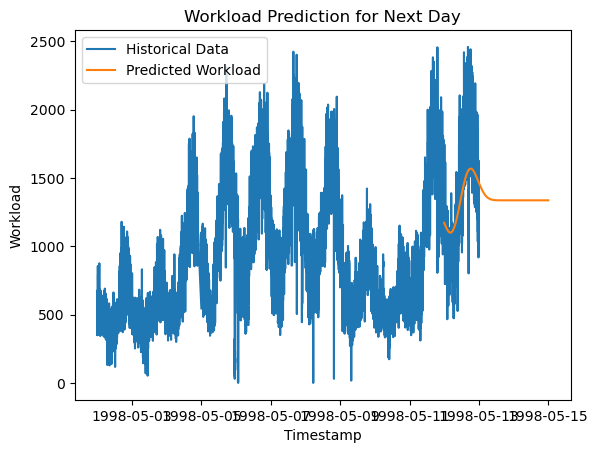

In [27]:
five_fays = first_date + pd.DateOffset(days=10)
last_five_days= pd.date_range(start=five_fays.replace(hour=0, minute=0, second=0), end=next_day+ pd.DateOffset(days=1), freq='T')
last_five_days_predictions = svr.predict(last_five_days.astype(int).values.reshape(-1, 1))

plt.plot(historical_df['timestamp'], historical_df['total_load'], label='Historical Data')

plt.plot(last_five_days, last_five_days_predictions, label='Predicted Workload')
plt.xlabel('Timestamp')
plt.ylabel('Workload')
plt.title('Workload Prediction for Next Day')
plt.legend()
plt.show()